In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_excel("/content/online_retail_II.xlsx")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
df.describe(include='object')

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


In [6]:
df["Description"].value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,3549
REGENCY CAKESTAND 3 TIER,2212
STRAWBERRY CERAMIC TRINKET BOX,1843
PACK OF 72 RETRO SPOT CAKE CASES,1466
ASSORTED COLOUR BIRD ORNAMENT,1457
...,...
stock credited from royal yacht inc,1
VINTAGE METAL CAKE STAND CREAM,1
BLUE BAROQUE FLOCK CANDLE HOLDER,1


In [7]:
df[df["Customer ID"].isna()]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [8]:
df[df["Quantity"] < 0].count()


,0
Invoice,12326
StockCode,12326
Description,10499
Quantity,12326
InvoiceDate,12326
Price,12326
Customer ID,9839
Country,12326


In [9]:
df["Invoice"] = df["Invoice"].astype("str")
df["StockCode"] = df["StockCode"].astype("str")



In [10]:
cleaned_df = df.copy()
mask = (
    cleaned_df["Invoice"].str.match("^\\d{6}$") |
    cleaned_df["StockCode"].str.match("^\\d{5}$") |
    cleaned_df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") |
    cleaned_df["StockCode"].str.match("^PADS$")
)
cleaned_df = cleaned_df[mask]

In [11]:
cleaned_df = cleaned_df[cleaned_df["Price"] > 0.0]
cleaned_df = cleaned_df[cleaned_df["Quantity"] > 0.0]
cleaned_df["TotalSale"] = cleaned_df["Quantity"] * cleaned_df["Price"]


In [12]:
aggregated_df = cleaned_df.groupby(by="Customer ID", as_index=False).agg(
    MonetaryValue=("TotalSale", "sum"),
    Frequency=("Invoice", "nunique"),
    LastInvoiceDate=("InvoiceDate", "max"),
    AverageOrderValue=("TotalSale", "mean"),
    Recency=("InvoiceDate", lambda x: (x.max() - x.min()).days),
    TotalQuantity=("Quantity", "sum"),
    DistinctProducts=("StockCode", "nunique"),
    FirstPurchaseDate=("InvoiceDate", "min"),
    ProductVariety=("StockCode", lambda x: len(set(x)))
)

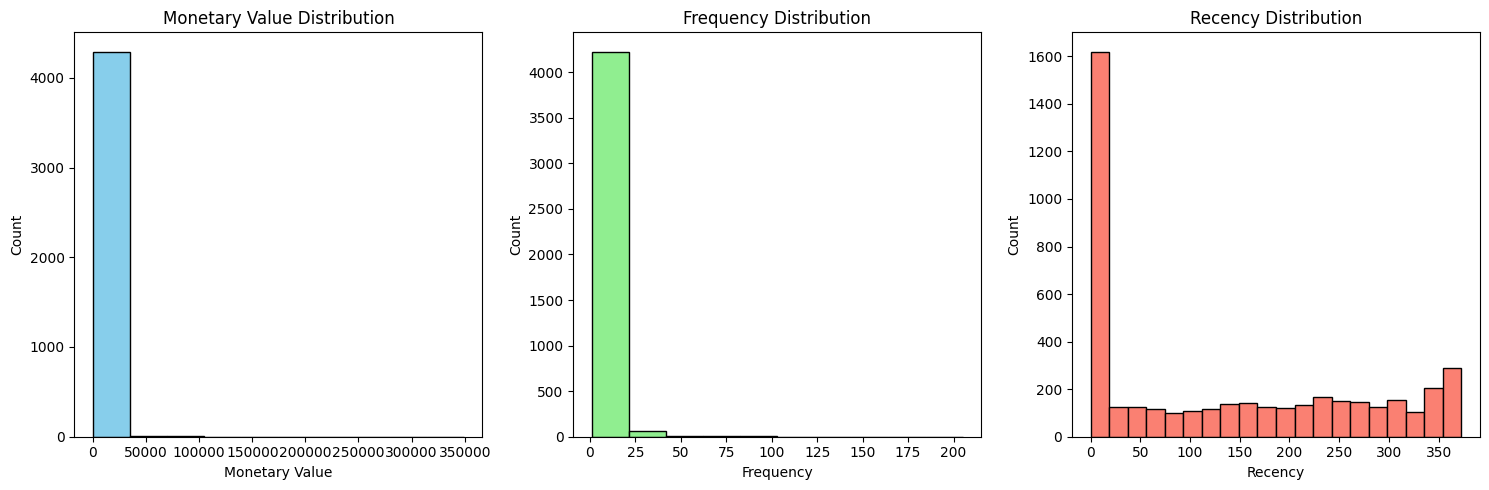

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

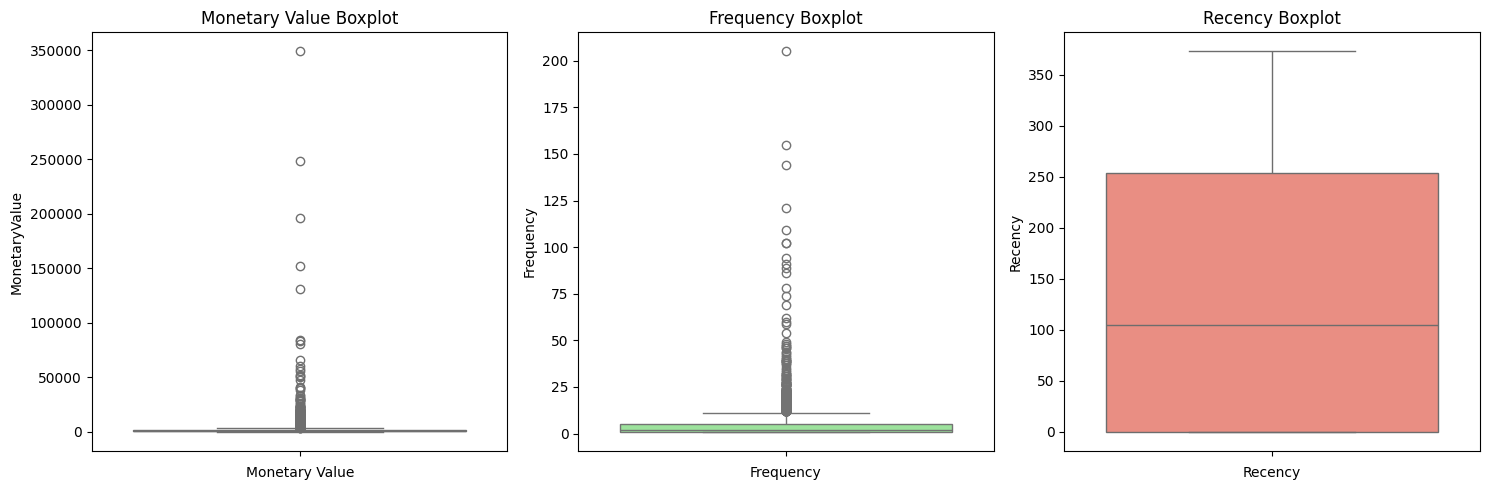

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [15]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[
    (aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))
].copy()

F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[
    (aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))
].copy()

In [16]:
# aggregated_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index))]
# aggregated_df.describe()
aggregated_df_filtered = aggregated_df[~aggregated_df.index.isin(monetary_outliers_df.index)]
aggregated_df_filtered = aggregated_df_filtered[~aggregated_df_filtered.index.isin(frequency_outliers_df.index)]



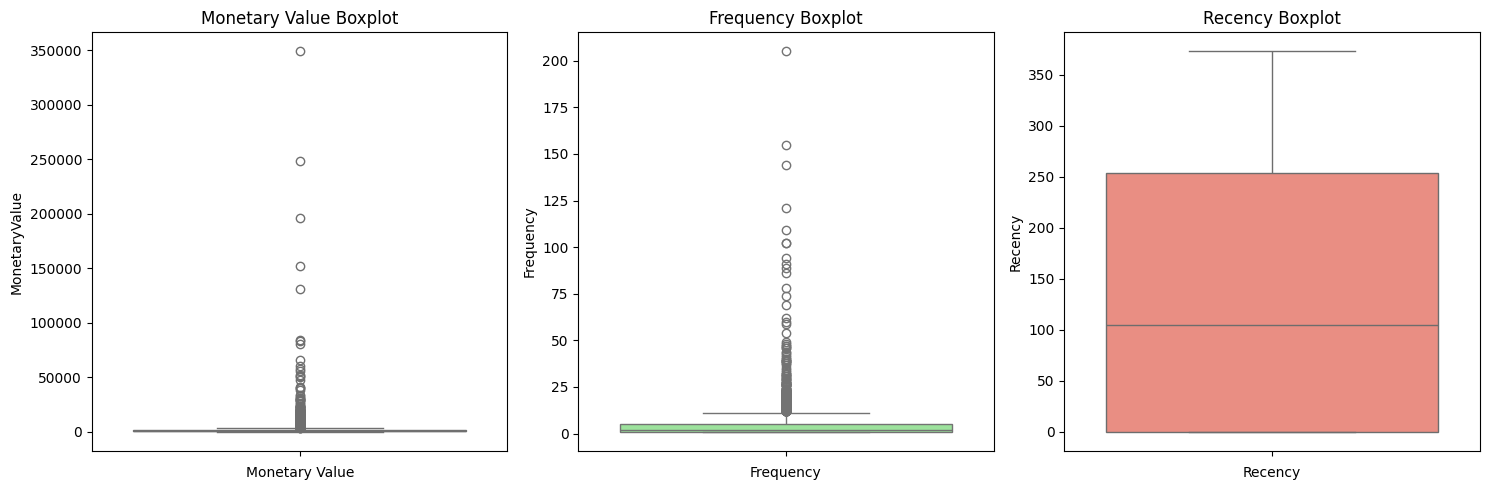

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(aggregated_df_filtered[["MonetaryValue", "Frequency", "Recency"]])
model_data_df = pd.DataFrame(scaled_data, index=aggregated_df_filtered.index, columns=["MonetaryValue", "Frequency", "Recency"])

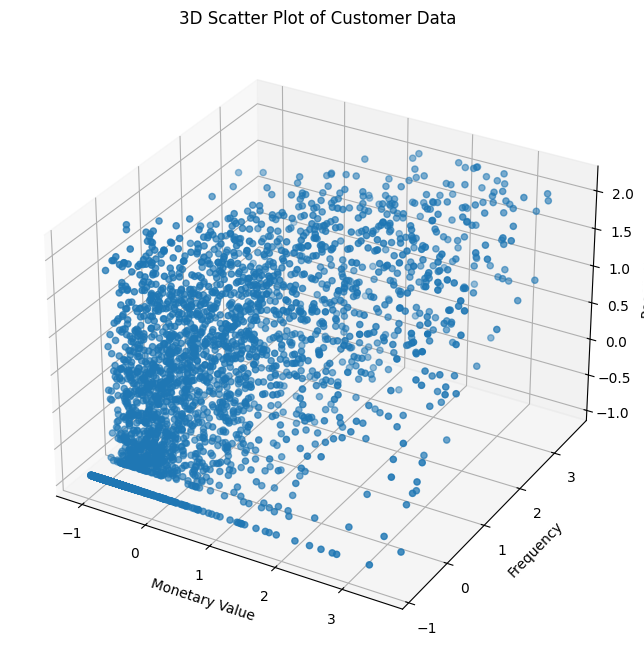

In [19]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
scatter = ax.scatter(model_data_df["MonetaryValue"], model_data_df["Frequency"], model_data_df["Recency"])
ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.set_title('3D Scatter Plot of Customer Data')
plt.show()

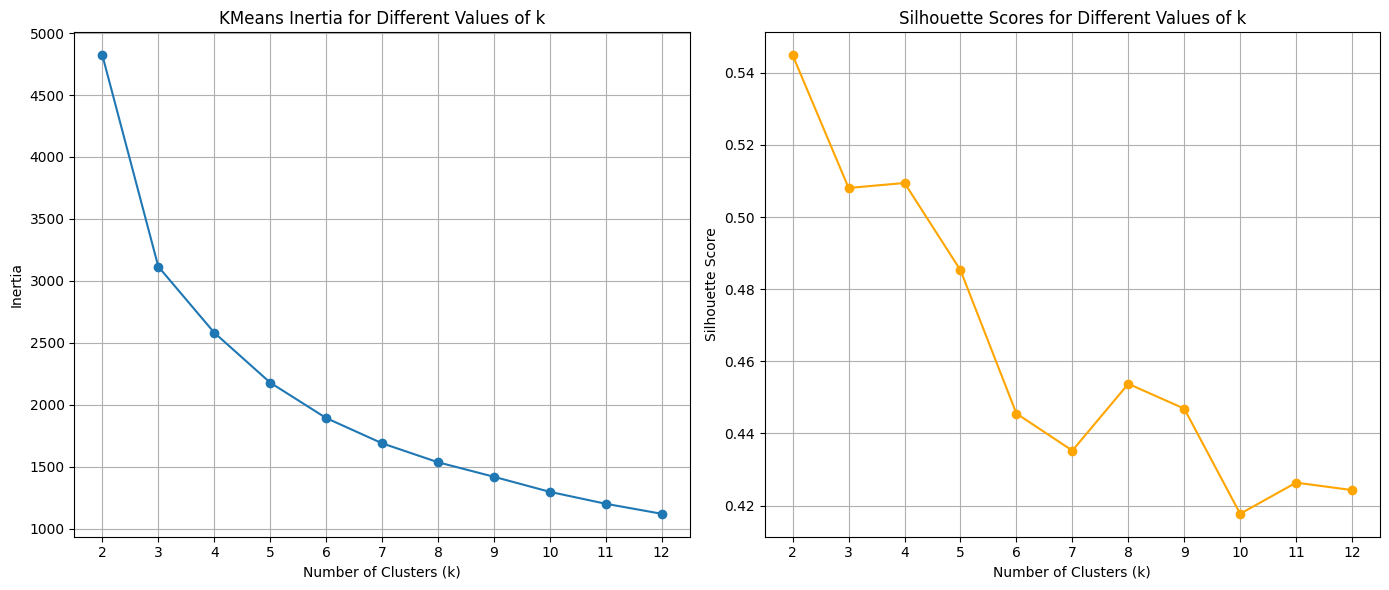

In [20]:
max_k = 12
inertia = []
silhouette_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(model_data_df)
    sil_score = silhouette_score(model_data_df, cluster_labels)
    silhouette_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(model_data_df)
aggregated_df_filtered["Cluster"] = cluster_labels


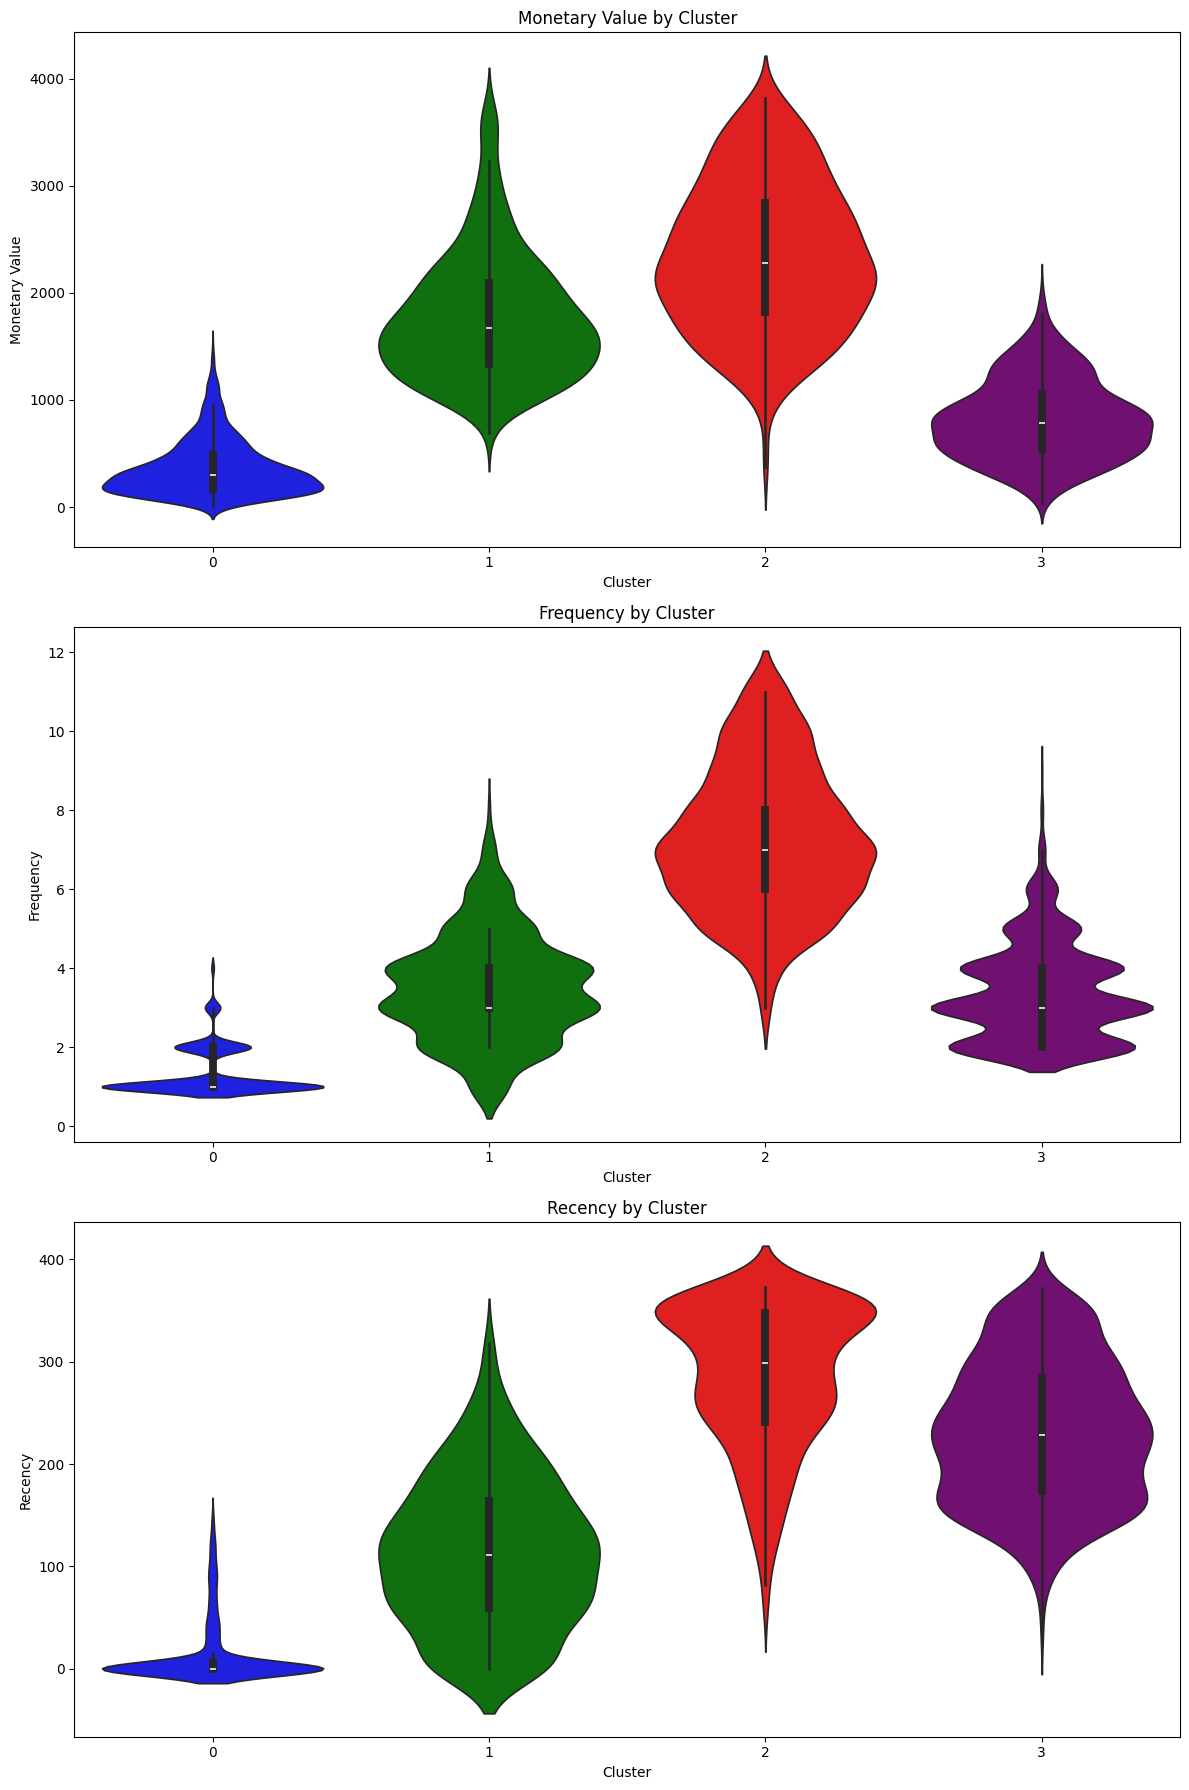

In [23]:
# Violin plots for the clustered data
cluster_colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=aggregated_df_filtered['Cluster'], y=aggregated_df_filtered['MonetaryValue'], hue=aggregated_df_filtered['Cluster'], palette=cluster_colors, legend=False)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=aggregated_df_filtered['Cluster'], y=aggregated_df_filtered['Frequency'], hue=aggregated_df_filtered['Cluster'], palette=cluster_colors, legend=False)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=aggregated_df_filtered['Cluster'], y=aggregated_df_filtered['Recency'], hue=aggregated_df_filtered['Cluster'], palette=cluster_colors, legend=False)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


In [24]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,AverageOrderValue,Recency,TotalQuantity,DistinctProducts,FirstPurchaseDate,ProductVariety,Cluster
9,12357.0,12079.99,2,2010-11-16 14:29:00,73.212061,0,3879,165,2010-11-16 10:05:00,165,-1
26,12380.0,6951.49,7,2010-08-31 14:54:00,40.182023,197,2228,119,2010-02-15 12:05:00,119,-1
44,12409.0,12346.62,4,2010-10-15 10:24:00,79.655613,144,7592,125,2010-05-23 15:21:00,125,-1
50,12415.0,19543.84,7,2010-11-29 15:07:00,92.187925,152,14073,169,2010-06-30 08:30:00,169,-1
64,12433.0,7205.39,5,2010-12-08 16:49:00,25.193671,110,6045,163,2010-08-20 09:23:00,163,-1
...,...,...,...,...,...,...,...,...,...,...,...
4262,18223.0,7516.31,12,2010-11-17 12:20:00,24.724704,348,3696,129,2009-12-04 12:20:00,129,-3
4263,18225.0,7545.14,15,2010-12-09 15:46:00,24.497208,369,4060,179,2009-12-04 16:52:00,179,-3
4264,18226.0,6650.83,15,2010-11-26 15:51:00,23.254650,266,4417,204,2010-03-05 10:05:00,204,-3
4268,18231.0,4797.70,23,2010-10-29 14:17:00,18.381992,292,2102,149,2010-01-10 12:13:00,149,-3


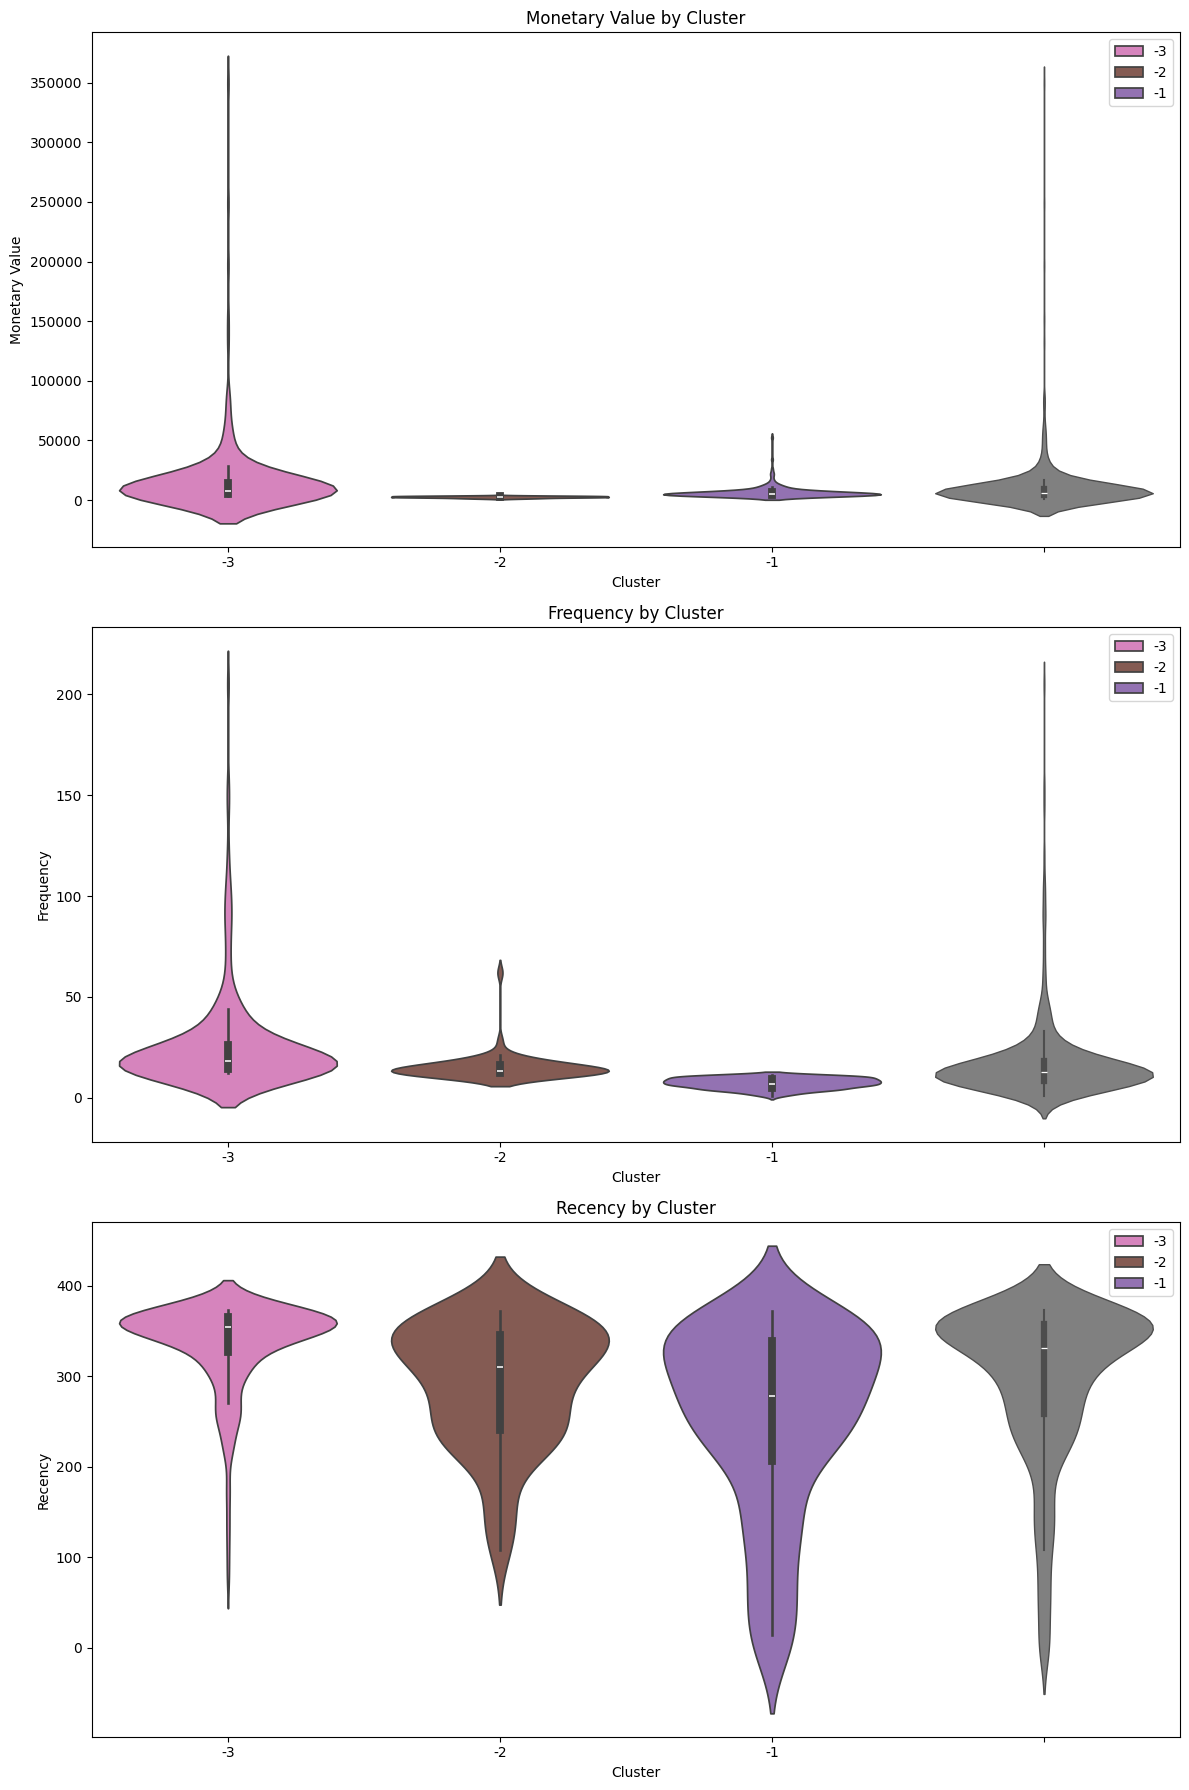

In [25]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [26]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

In [29]:
cluster_counts = aggregated_df_filtered['Cluster'].value_counts()
aggregated_df_filtered["MonetaryValue per 100 pounds"] = aggregated_df_filtered["MonetaryValue"] / 100.00
feature_means = aggregated_df_filtered.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()


<ipython-input-30-ff33929eea41>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis')


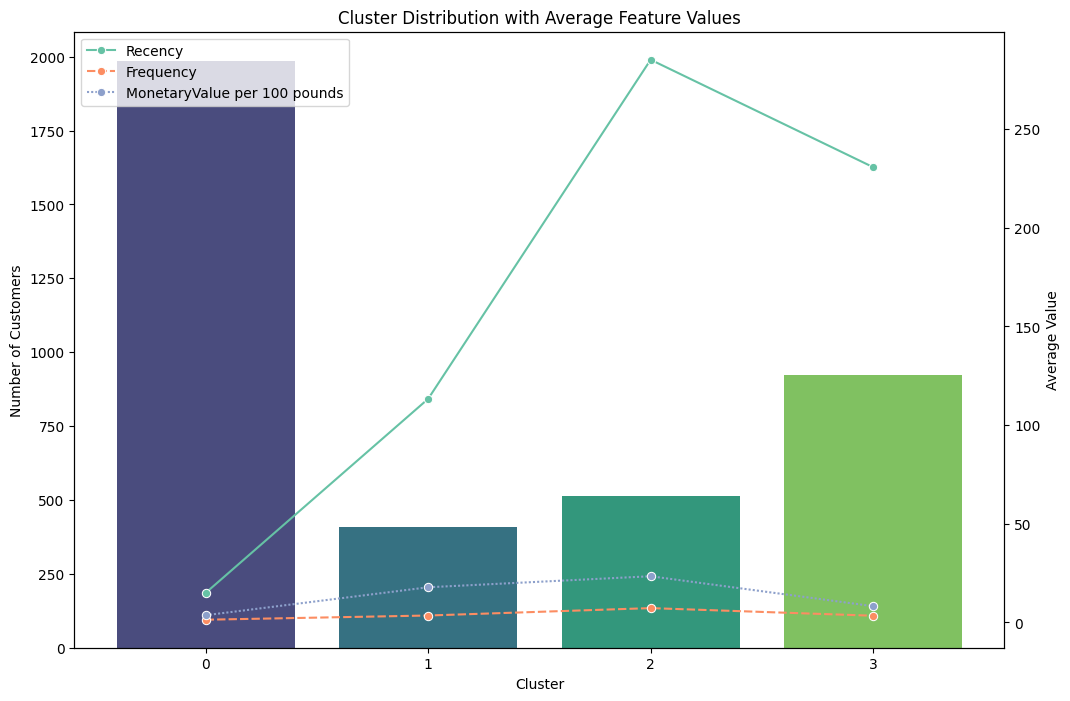

In [30]:
fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()
sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value')

plt.show()